# 4.2.5 Challenge: Boston Marathon

__Challenge Info:__ There is a lot of information on runners and their performance for the Boston Marathon. Pick a year and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish.

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Model imports
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

# Cluster evalutations
from sklearn import metrics

Importing results data from [2013 Boston Marathon Database](https://github.com/llimllib/bostonmarathon).

In [2]:
results_2013 = pd.read_csv('2013results.csv')
results_2013.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


Inspect the data types and number of non-null values.

In [3]:
results_2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 2.6+ MB


Looks like ctz has very few non-null values. I also can't figure out what that column includes.  We should drop this column. 

Let's also check out how many unique values each column contains

In [4]:
results_2013 = results_2013.drop('ctz', axis=1)

In [5]:
results_2013.nunique()

25k           3245
age             61
name         16137
division      3698
10k           1459
gender           2
half          2761
official      5370
bib          16157
country         68
overall      16107
pace           362
state           65
30k           3862
5k             808
genderdiv     9812
20k           2644
35k           4539
city          4416
40k           5136
dtype: int64

It looks like each person has their own name (obviously) and bib number. I will remove these from the data set.  The overall column appears to be the runner's overall place in the marathon. 

I will also make sure that gender gets assigned a dummy variable (0 is for Females, 1 for Males).

In [6]:
results_2013 = results_2013.drop(['name', 'bib'], axis=1)
results_2013.gender = results_2013.gender.map(lambda x: 0 if x is 'F' else 1)

In [7]:
results_2013.tail()

,25k,age,division,10k,gender,half,official,country,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
16159,144.85,65,6,57.57,0,121.98,247.47,USA,17014,9.45,WA,174.75,28.50,6686,115.63,204.83,Vancouver,234.48
16160,133.32,64,258,52.80,1,112.27,229.72,USA,13796,8.77,NY,161.00,26.57,9024,106.38,189.82,Tully,217.88
16161,139.83,75,3,54.97,1,117.58,239.97,CAN,16083,9.17,NS,168.82,27.48,9994,111.45,198.42,Halifax,227.53
16162,135.38,80,1,53.13,1,113.80,233.90,USA,14768,8.93,TX,164.02,26.93,9434,107.85,192.80,Tyler,221.42
16163,144.95,61,49,57.57,0,121.55,249.15,USA,17144,9.52,CA,175.82,28.93,6762,115.32,206.67,Berkeley,235.85


In [8]:
results_2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 18 columns):
25k          16164 non-null object
age          16164 non-null int64
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null int64
half         16164 non-null object
official     16164 non-null float64
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(5), object(11)
memory usage: 2.2+ MB


It looks like all of the split times are actually in the data frame as objects.  Let's change those to floats. After further inspection it's because there are '-'s in the data.  I will replace those with the mean values for each category.

In [9]:
splits = ['5k', '10k', 'half', '20k', '25k', '30k', '35k', '40k']

for dist in splits:
    results_2013[dist] = pd.to_numeric(results_2013[dist], errors='coerce')
    results_2013[dist] = results_2013[dist].map(lambda x: results_2013[dist].mean() if x is '-' else float(x))

results_2013.head()

,25k,age,division,10k,gender,half,official,country,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,9,18.18,1,40.93,90.90,CAN,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,5,30.90,1,64.90,132.50,KEN,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,1,30.90,1,64.92,130.37,ETH,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,5,18.73,1,42.00,88.43,AUS,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,3,18.18,1,40.57,87.22,JPN,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


Just in case, let's check the types of each column. 

In [10]:
results_2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 18 columns):
25k          16141 non-null float64
age          16164 non-null int64
division     16164 non-null int64
10k          16138 non-null float64
gender       16164 non-null int64
half         16148 non-null float64
official     16164 non-null float64
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16147 non-null float64
5k           16098 non-null float64
genderdiv    16164 non-null int64
20k          16147 non-null float64
35k          16143 non-null float64
city         16163 non-null object
40k          16147 non-null float64
dtypes: float64(10), int64(5), object(3)
memory usage: 2.2+ MB


Great! Now let's try and see what our distributions of country, state, and city are.

In [11]:
results_2013.country.value_counts().head(20)

USA    13167
CAN     1533
GBR      179
JPN      109
MEX      108
GER       86
BRA       81
AUS       78
ITA       76
FRA       66
ESP       51
SWE       48
DEN       45
NED       42
SUI       37
HKG       32
COL       29
IRL       28
SIN       23
AUT       22
Name: country, dtype: int64

In [12]:
results_2013.state.value_counts().head(20)

CA    1347
MA    1043
NY    1004
IL     732
ON     717
PA     661
TX     656
OH     519
VA     455
MN     415
MI     404
WA     391
FL     384
CO     365
WI     352
NJ     352
MD     327
NC     315
QC     298
OR     256
Name: state, dtype: int64

In [13]:
results_2013.city.value_counts().head(20)

New York         318
Chicago          273
Toronto          161
Austin           134
Portland         132
Washington       124
San Francisco    109
Boston           104
Seattle           99
Brooklyn          98
Houston           97
Ottawa            92
Calgary           86
London            85
San Diego         83
Denver            80
Cambridge         79
Arlington         78
Atlanta           78
Dallas            78
Name: city, dtype: int64

Looks like all three have too many values to create any kind of meaningful groups.  let's not include these in our models and then re-evaluate if our models aren't very good. 

In [14]:
X = results_2013.drop(['country', 'city', 'state'], axis=1)

Great, now let's normalize the data and create a 2-feature PCA for graphing purposes.

In [15]:
Xn = normalize(X.dropna(axis=0, how='any'))
print(len(Xn))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xn)

16054


Now, lets separate the data into four equal sets for cross validation.

In [16]:
# Divide into two sets.
Xhalf1, Xhalf2, X_pca_1, X_pca_2 = train_test_split(Xn, X_pca, test_size=0.5, random_state=42)
# Divide into four sets
X1, X2, X_pca1, X_pca2 = train_test_split(Xhalf1, X_pca_1, test_size=0.5, random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(Xhalf2, X_pca_1, test_size=0.5, random_state=42)

# Check the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

4013 4013
4014 4014
4013 4013
4014 4014


In [17]:
# Ensuring all sets are the same length
X2 = X2[:4013][:]
X4 = X4[:4013][:]

X_pca2 = X_pca2[:4013][:]
X_pca4 = X_pca4[:4013][:]

print(len(X2), len(X_pca2))
print(len(X4), len(X_pca4))

4013 4013
4013 4013


## K Means Modeling
Now, let's create two data frames, one for the y predictions from a kmeans model, and the second for the silhouette scores for the different clusters, and then model for 2-5 clusters, pulling silhouette scores for each. 

In [18]:
# Initialize data frames
ypred = pd.DataFrame()
score = pd.DataFrame(columns=['cluster_pred','sil_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
       
        # Instantiating and fit_predicting model to then add to data frame
        kmeans = KMeans(n_clusters=nclust, random_state=42)
        pred = kmeans.fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = kmeans.labels_
        sscore = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score = score.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'sil_score':sscore}, ignore_index=True)
        

In [19]:
# Sorting sihoilette scores
score.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score
7,clust5_sample1,0.634536
2,clust4_sample0,0.633268
11,clust5_sample2,0.632638
6,clust4_sample1,0.631976
15,clust5_sample3,0.631302
10,clust4_sample2,0.630755
14,clust4_sample3,0.630060
9,clust3_sample2,0.601554
5,clust3_sample1,0.599485
1,clust3_sample0,0.595198


According to our models, a four-cluster system is has the highest silhouette scores and is most consistent across folds. 

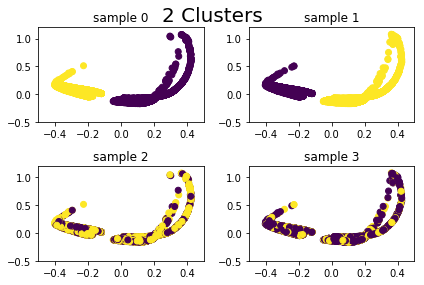

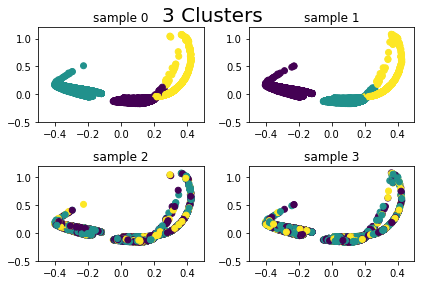

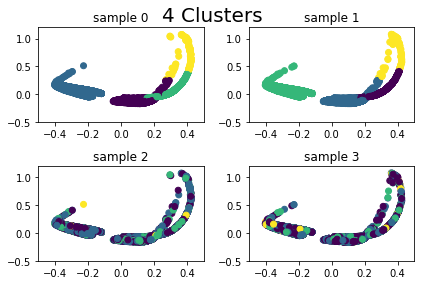

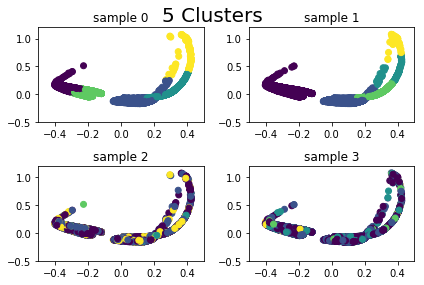

In [20]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.5, .5])
        axarr[rows, cols].set_ylim([-.5, 1.2])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

According to the graphs of the 2-feature PCA data, the 4-cluster solution is consistent across samples 0 and 1, but inconsistent across samples 2 and 3. 

## Mean-shift
Now, let's do the same thing for a mean-shift model, using a range of quantiles used to create the bandwidths, from 0.1 to 0.4, pulling silhouette scores for each. 

In [21]:
# Initialize new data frames
ypred_ms = pd.DataFrame()
score_ms = pd.DataFrame(columns=['cluster_pred','mean_shift', 'quantile'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Creating a list of possible quantiles to test in mean shift.
    for n in [0.1, 0.2, 0.3, 0.4]:
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=500)
        # Ensuring all sets are the same lenght
        data = data[:4013][:]
        # Instantiating and fit_predicting model to then add to data frame
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        cntrs = len(np.unique(labels))
        ypred_ms['clust' + str(cntrs) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        sscore = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms = score_ms.append({'cluster_pred':'clust' + str(cntrs) + '_sample' + str(counter), 
                              'mean_shift':sscore, 'quantile':n}, ignore_index=True)

In [22]:
score_ms.sort_values(by='mean_shift', ascending=False)

,cluster_pred,mean_shift,quantile
15,clust2_sample3,0.666912,0.4
5,clust5_sample1,0.634905,0.2
1,clust4_sample0,0.633391,0.2
2,clust6_sample0,0.632797,0.3
13,clust5_sample3,0.630324,0.2
6,clust4_sample1,0.629312,0.3
10,clust4_sample2,0.628176,0.3
14,clust4_sample3,0.624060,0.3
9,clust3_sample2,0.600894,0.2
8,clust7_sample2,0.556527,0.1


It looks like while the quantile of 0.4 had a high silhouette score for sample 3 (which created 2 clusters), the samples with 5-6 clusters appeared to have the highest silhouette scores.

## Spectral Clustering
Now, let's again do the same thing for a spectral clustering model, using a range of clusters from 2-5, and again pulling silhouette scores for each. 

In [23]:
# Initialize data frames
ypred_sc = pd.DataFrame()
score_sc = pd.DataFrame(columns=['cluster_pred','sil_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_sc['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_sc['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
        # Instantiating and fit_predicting model to then add to data frame
        sc = SpectralClustering(n_clusters=nclust)
        pred = sc.fit_predict(data[0])
        ypred_sc['clust' + str(nclust) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = sc.labels_
        sscore_sc = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_sc = score_sc.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'sil_score':sscore_sc}, ignore_index=True)

In [24]:
score_sc.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score
2,clust4_sample0,0.632524
6,clust4_sample1,0.631643
10,clust4_sample2,0.629541
14,clust4_sample3,0.629010
7,clust5_sample1,0.620887
15,clust5_sample3,0.619137
9,clust3_sample2,0.579940
5,clust3_sample1,0.577374
13,clust3_sample3,0.559547
1,clust3_sample0,0.551438


For this model, it appears that 4 clusters has consistently the highest silhouette score for all of the samples, followed closely by 5 clusters. 

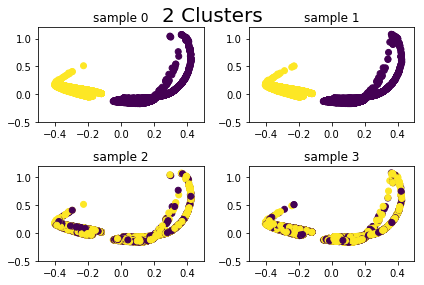

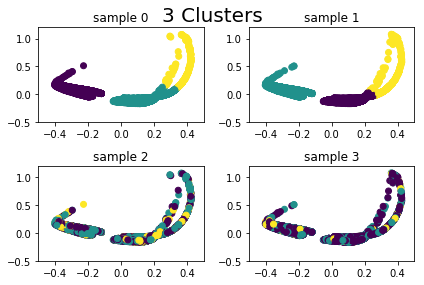

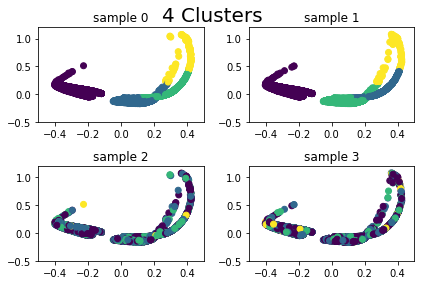

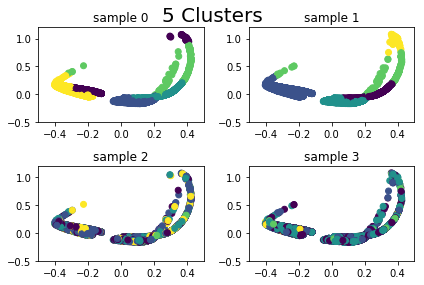

In [25]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred_sc['pca_f1_sample{}'.format(i)]
        y_sub = ypred_sc['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred_sc['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.5, .5])
        axarr[rows, cols].set_ylim([-.5, 1.2])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

## Affinity Propagation
Finally, let's do the same thing for the affinity propagation model, allowing the model to identify the number of cluster centers and then pulling silhouette scores. 

In [26]:
# Initialize data frames
ypred = pd.DataFrame()
score_af = pd.DataFrame(columns=['cluster_pred','AF'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Ensuring all sets are the same lenght
    data = data[:4013][:]
    # Instantiating and fit_predicting model to then add to data frame
    af = AffinityPropagation().fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    #pred = af.fit_predict(data)
    #ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
    # Calculating silhouette scores for the data and adding that to the shilouette score
    labels = af.labels_
    sscore_af = metrics.silhouette_score(data, labels, metric='euclidean')
    score_af = score_af.append({'cluster_pred':'clust' + str(n_clusters_) + '_sample' + str(counter), 
                              'AF':sscore_af}, ignore_index=True)

In [27]:
score_af.sort_values(by='AF', ascending=False)

,cluster_pred,AF
1,clust2270_sample1,0.154947
3,clust2195_sample3,0.103732
0,clust3282_sample0,0.056982
2,clust3492_sample2,0.045999


This model again, as in the last data set, pulled an absurd number of clusters, and had a very small silhouette score. I might consider tuning some of the other parameters of this model, but this seems like an unreliable unsupervised learning model.

# Summary of Models

Overall, the four-cluster solution have the highest silhouette scores, and the silhouette scores for the four-cluster solutions were highest for the k-means models, with a silhouette score of 0.630.  This means that there are four main groups of runners in the Boston Marathon.